**To-Do:**
- `pd.get_dummies()` on day, week, and month
- What's highly correlated to our target?
- % of orders on a given date
- correlation between week and day and target
- Week of month - x, day of month - y, % of orders - z

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
df = pd.read_csv("../data/Daily_Demand_Forecasting_Orders.csv")

**Clean up column headers**

In [3]:
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [4]:
df.rename(columns=lambda x: x.replace('(', ''), inplace=True)
df.rename(columns=lambda x: x.replace(')', ''), inplace=True)

**Create Month Column**

In [5]:
month_col = {}
month_col = month_col.fromkeys(df.index)

In [6]:
prior_row = 1
month = 1

for index, row in df.iterrows():
    if row['Week_of_the_month'] >= prior_row:
        month_col[index] = month
    else:
        month += 1
        month_col[index] = month
    
    prior_row = row['Week_of_the_month']

In [7]:
df['month'] = df.index.to_series().map(month_col)

**Info on data**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
Week_of_the_month                            60 non-null int64
Day_of_the_week_Monday_to_Friday             60 non-null int64
Non-urgent_order                             60 non-null float64
Urgent_order                                 60 non-null float64
Order_type_A                                 60 non-null float64
Order_type_B                                 60 non-null float64
Order_type_C                                 60 non-null float64
Fiscal_sector_orders                         60 non-null float64
Orders_from_the_traffic_controller_sector    60 non-null int64
Banking_orders_1                             60 non-null int64
Banking_orders_2                             60 non-null int64
Banking_orders_3                             60 non-null int64
Target_Total_orders                          60 non-null float64
month                                        60 non-null int64
d

In [9]:
df.shape

(60, 14)

**Correlation Heatmap**

In [10]:
df_corr = df.corr()

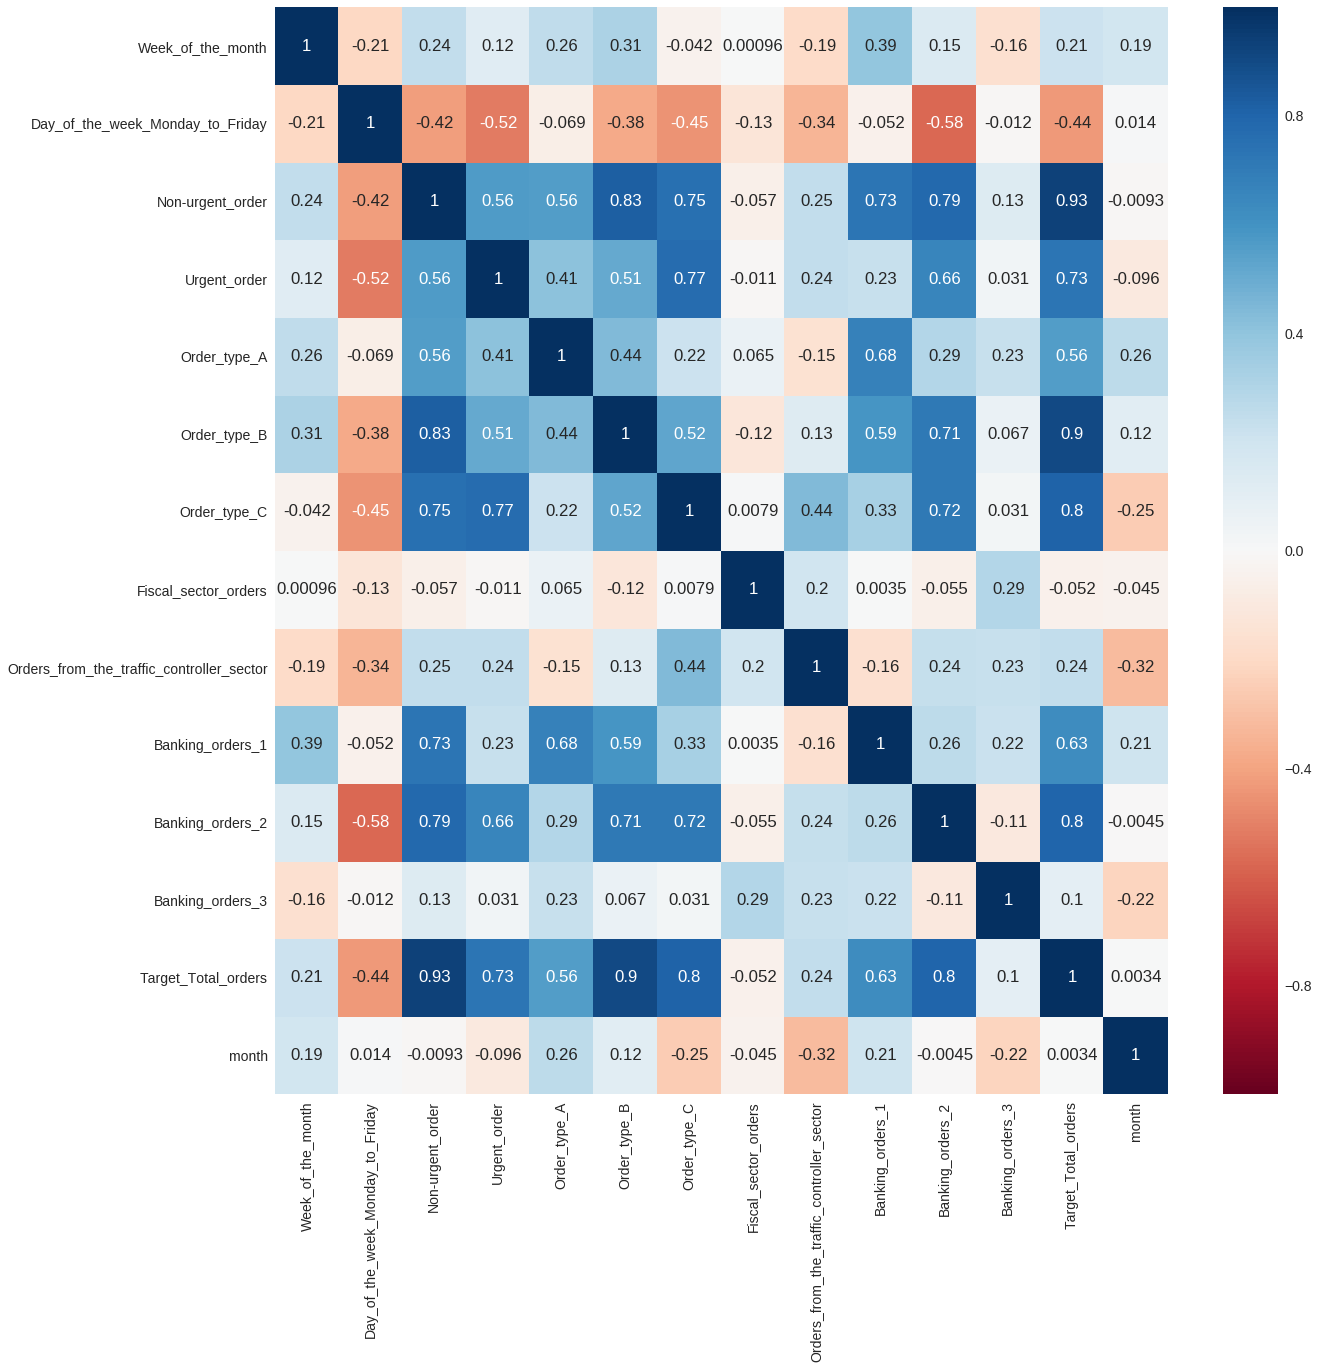

In [11]:
plt.figure(figsize = (20,20))
sns.set(font_scale=1.4)
sns.heatmap(df_corr, cmap='RdBu', annot=True)

** Feature Correlation: **
Selecting features that are highly correlated with other features and storing the indexes. 
1. `hi_corrs` sets the threshold for 'highly correlated'. 
2. `hi_count` makes sure it's identifying those features that are highly correlated to at least 2 features (itself and 1 other). 
3. `top_corrs` stores those indexes to a list.

In [12]:
hi_corrs = df_corr.abs() > .75
hi_count = df_corr[hi_corrs].count() > 1
top_corrs = list(df_corr[hi_count].index)

In [13]:
print(len(top_corrs), top_corrs)

6 ['Non-urgent_order', 'Urgent_order', 'Order_type_B', 'Order_type_C', 'Banking_orders_2', 'Target_Total_orders']


**Distributions**

In [14]:
df_trim = df[top_corrs]

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


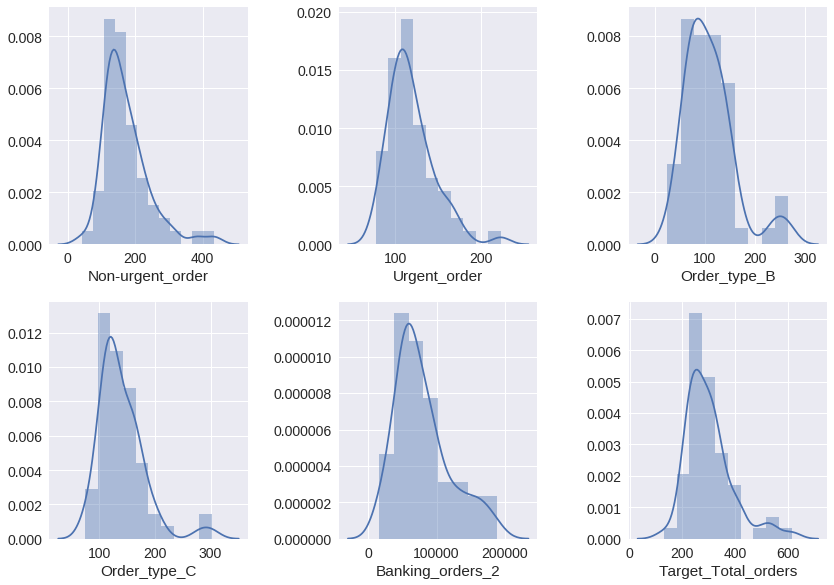

In [15]:
fig = plt.figure(figsize = (12,12))

for i, col in enumerate(df_trim.columns):
    fig.add_subplot(3,3,1+i)
    sns.distplot(df_trim[col])
    
    
fig.tight_layout()
fig.show()

**Add ticks for easy sort on time**

In [16]:
df.Week_of_the_month.unique()

array([1, 2, 3, 4, 5])

In [17]:
df.Day_of_the_week_Monday_to_Friday.unique()

array([4, 5, 6, 2, 3])

In [18]:
df['ticks'] = range(0, len(df.index.values))

**Target over Time**

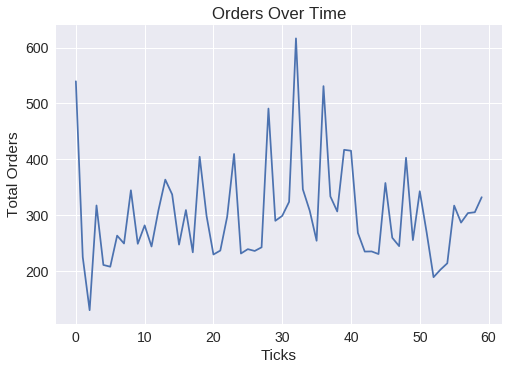

In [19]:
fig = plt.figure(1)
sub1 = fig.add_subplot(111)
sub1.set_xlabel('Ticks')
sub1.set_ylabel('Total Orders')
sub1.set_title('Orders Over Time')
sub1.plot('ticks', 'Target_Total_orders', data = df)

In [20]:
df['rolling_mean'] = df['Target_Total_orders'].rolling(window = 5).mean()

(0, 650)

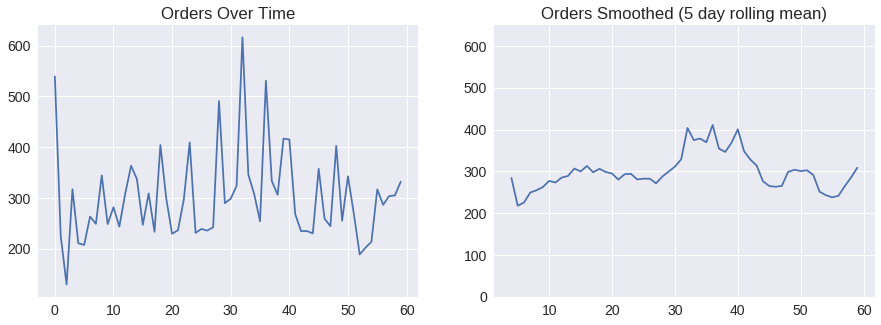

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5));
axes[0].plot('ticks', 'Target_Total_orders', data = df);
axes[0].set_title('Orders Over Time');
axes[1].plot('ticks', 'rolling_mean', data = df)
axes[1].set_title('Orders Smoothed (5 day rolling mean)')
axes[1].set_ylim([0,650])

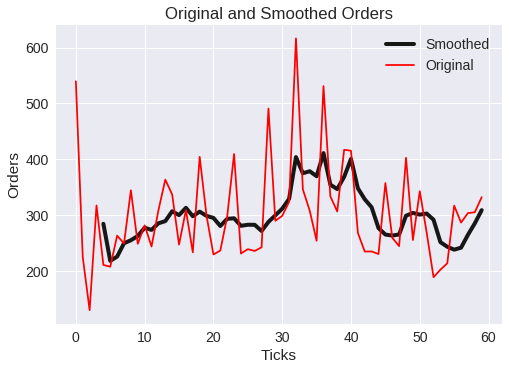

In [22]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(df['ticks'], df['rolling_mean'], color=(0,0,0), linewidth=4, alpha=.9, label='Smoothed')
sub.plot(df['ticks'], df['Target_Total_orders'], color=(1,0,0), label='Original')
sub.set_title('Original and Smoothed Orders')
sub.set_xlabel('Ticks')
sub.set_ylabel('Orders')
sub.legend(loc='upper right')

In [23]:
df.head()

,Week_of_the_month,Day_of_the_week_Monday_to_Friday,Non-urgent_order,Urgent_order,Order_type_A,Order_type_B,Order_type_C,Fiscal_sector_orders,Orders_from_the_traffic_controller_sector,Banking_orders_1,Banking_orders_2,Banking_orders_3,Target_Total_orders,month,ticks,rolling_mean
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577,1,0,NaN
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675,1,1,NaN
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412,1,2,NaN
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120,1,3,NaN
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517,1,4,284.2602


**Fixing columns so everything is on same scale**

In [29]:
df.iloc[:,2:8] = df.iloc[:,2:8]*1000
df.iloc[:,12] = df.iloc[:,12]*1000

**Sanity check the data**

In [24]:
sample = df.head(1)

In [25]:
sample

,Week_of_the_month,Day_of_the_week_Monday_to_Friday,Non-urgent_order,Urgent_order,Order_type_A,Order_type_B,Order_type_C,Fiscal_sector_orders,Orders_from_the_traffic_controller_sector,Banking_orders_1,Banking_orders_2,Banking_orders_3,Target_Total_orders,month,ticks,rolling_mean
0,1,4,316.307,223.27,61.543,175.586,302.448,0.0,65556,44914,188411,14793,539.577,1,0,NaN


In [26]:
total = sample['Target_Total_orders']

In [31]:
order_accum = sample.iloc[0,2:4].sum()

In [33]:
print(total == order_accum)

0    True
Name: Target_Total_orders, dtype: bool


*Notes on how columns add up*
- Non urgent and urgent orders = total
- Order A, B, and C = total